In [ ]:
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Хакатоны/CUP_IT_25/Датасеты итоговые/daily.csv')
df.head()

,service_date,unique_patients,hospital_ammount,non_hospital_ammount,hospital_unique_patients,unique_service_codes,high_cost_proportion,service_code_hhi,mean_ammount,total_racords,lag_1,lag_7,lag_14,rolling_mean_7,rolling_mean_14,EMA_7,EMA_14,total_amount_net
0,2022-01-01,33,0.00,159311.20,0,57,0.212500,0.023125,1991.390000,80,522701.276667,767077.931429,1.298460e+06,NaN,NaN,159311.200000,159311.200000,159311.20
1,2022-01-02,84,26930.00,486975.29,1,158,0.201729,0.012233,1480.995072,347,250158.719167,767077.931429,1.298460e+06,NaN,NaN,361936.394286,349272.319643,513905.29
2,2022-01-03,163,12827.22,882060.12,1,217,0.191104,0.013253,1474.278979,607,432752.498974,767077.931429,1.298460e+06,522701.276667,522701.276667,592401.668108,557699.110102,894887.34
3,2022-01-04,150,28827.86,871642.62,2,219,0.232975,0.010778,1613.746380,558,744693.516667,767077.931429,1.298460e+06,617143.577500,617143.577500,705066.833600,662562.541339,900470.48
4,2022-01-05,176,59126.81,1118811.58,5,267,0.196742,0.010584,1476.113271,798,848973.963196,767077.931429,1.298460e+06,729302.540000,729302.540000,860066.985250,797023.311684,1177938.39


DEBUG:cmdstanpy:input tempfile: /tmp/tmpm1eq6vsq/yjx0tfjo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm1eq6vsq/0v7r2yaa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=214', 'data', 'file=/tmp/tmpm1eq6vsq/yjx0tfjo.json', 'init=/tmp/tmpm1eq6vsq/0v7r2yaa.json', 'output', 'file=/tmp/tmpm1eq6vsq/prophet_modelg100qcqm/prophet_model-20250330193416.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:34:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:34:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ds, trend, yhat_lower, yhat_upper, trend_lower, trend_upper, EMA_7, EMA_7_lower, EMA_7_upper, additive_terms, additive_terms_lower, additive_terms_upper, extra_regressors_additive, extra_regressors_additive_lower, extra_regressors_additive_upper, high_cost_proportion, high_cost_proportion_lower, high_cost_proportion_upper, hospital_ammount, hospital_ammount_lower, hospital_ammount_upper, hospital_unique_patients, hospital_unique_patients_lower, hospital_unique_patients_upper, lag_1, lag_1_lower, lag_1_upper, lag_14, lag_14_lower, lag_14_upper, lag_7, lag_7_lower, lag_7_upper, mean_ammount, mean_ammount_lower, mean_ammount_upper, non_hospital_ammount, non_hospital_ammount_lower, non_hospital_ammount_upper, service_code_hhi, service_code_hhi_lower, service_code_hhi_upper, total_racords, total_racords_lower, total_racords_upper, unique_patients, unique_patients_lower, unique_patients_upper, unique_service_codes, unique_service_codes_lower, unique_service_codes_upper, weekly, weekly_lower,

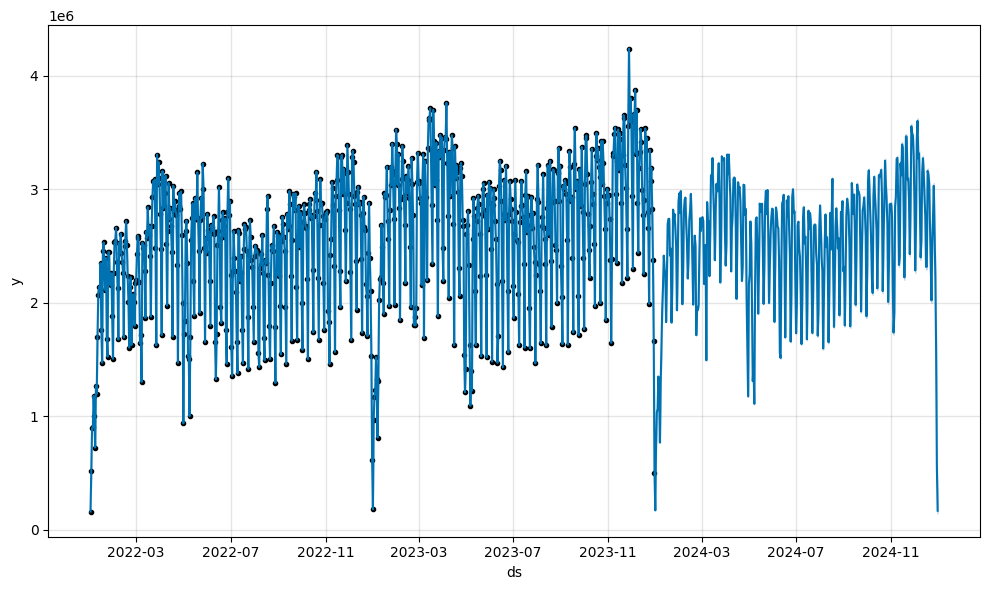

In [ ]:
regressors = [
    'unique_patients', 'hospital_ammount', 'non_hospital_ammount',
    'hospital_unique_patients', 'unique_service_codes', 'high_cost_proportion', 'service_code_hhi', 'mean_ammount',
    'total_racords', 'lag_1', 'lag_7', 'lag_14',
    'EMA_7'
]

df_prophet = df[['service_date', 'total_amount_net'] + regressors].copy()
df_prophet.columns = ['ds', 'y'] + regressors


graph = df[['service_date', 'total_amount_net']].copy()
graph.columns = ['ds', 'y']


df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])


df_prophet = df_prophet.dropna()



model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

model.add_regressor('unique_patients')
model.add_regressor('hospital_ammount')
model.add_regressor('non_hospital_ammount')
model.add_regressor('hospital_unique_patients')
model.add_regressor('unique_service_codes')
model.add_regressor('high_cost_proportion')
model.add_regressor('service_code_hhi')
model.add_regressor('hospital_ammount')
model.add_regressor('mean_ammount')
model.add_regressor('unique_service_codes')
model.add_regressor('total_racords')
model.add_regressor('lag_1')
model.add_regressor('lag_7')
model.add_regressor('lag_14')
model.add_regressor('EMA_7')

model.fit(df_prophet)

future_dates = model.make_future_dataframe(periods=366)

for regressor in regressors:
    for i in range(730):
      future_dates.loc[i, regressor] = df_prophet[regressor].iloc[i]
    for i in range(730, 1096):
      future_dates.loc[i, regressor] = (df_prophet[regressor].iloc[i % 365] + df_prophet[regressor].iloc[i % 365 + 365]) / 2

forecast = model.predict(future_dates)

forecast_2024 = forecast[forecast['ds'].dt.year == 2024].copy()

forecast_2024['month'] = forecast_2024['ds'].dt.to_period('M')  # Extract year-month
monthly_forecast = forecast_2024.groupby('month').agg({
    'yhat': 'sum'
}).reset_index()

monthly_forecast.columns = ['Месяц', 'Предсказанная сумма выплат']

monthly_forecast['Месяц'] = monthly_forecast['Месяц'].astype(str)

monthly_forecast.to_excel('forecast.xlsx', index=False)



model.plot(forecast)

print(', '.join(forecast.columns))


In [ ]:
df.head(2)

,unique_patients,hospital_ammount,non_hospital_ammount,hospital_unique_patients,unique_service_codes,high_cost_proportion,service_code_hhi,mean_ammount,total_racords,lag_1,lag_7,lag_14,rolling_mean_7,rolling_mean_14,EMA_7,EMA_14,total_amount_net
service_date,,,,,,,,,,,,,,,,,
2022-01-01,33,0.0,159311.20,0,57,0.212500,0.023125,1991.390000,80,522701.276667,767077.931429,1.298460e+06,NaN,NaN,159311.200000,159311.200000,159311.20
2022-01-02,84,26930.0,486975.29,1,158,0.201729,0.012233,1480.995072,347,250158.719167,767077.931429,1.298460e+06,NaN,NaN,361936.394286,349272.319643,513905.29


DEBUG:cmdstanpy:input tempfile: /tmp/tmpm1eq6vsq/n408use1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm1eq6vsq/se5besbd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89681', 'data', 'file=/tmp/tmpm1eq6vsq/n408use1.json', 'init=/tmp/tmpm1eq6vsq/se5besbd.json', 'output', 'file=/tmp/tmpm1eq6vsq/prophet_modelbjp8exdx/prophet_model-20250330200458.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:04:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:04:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-42-c556417f16bc>:54: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

<ipython-input-42-c556417f16bc>:55: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



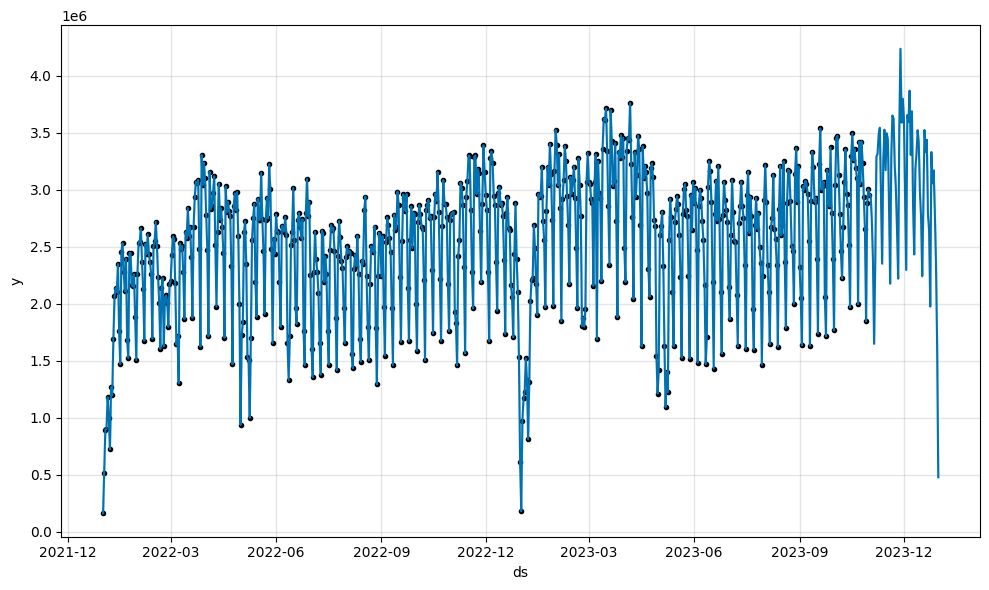

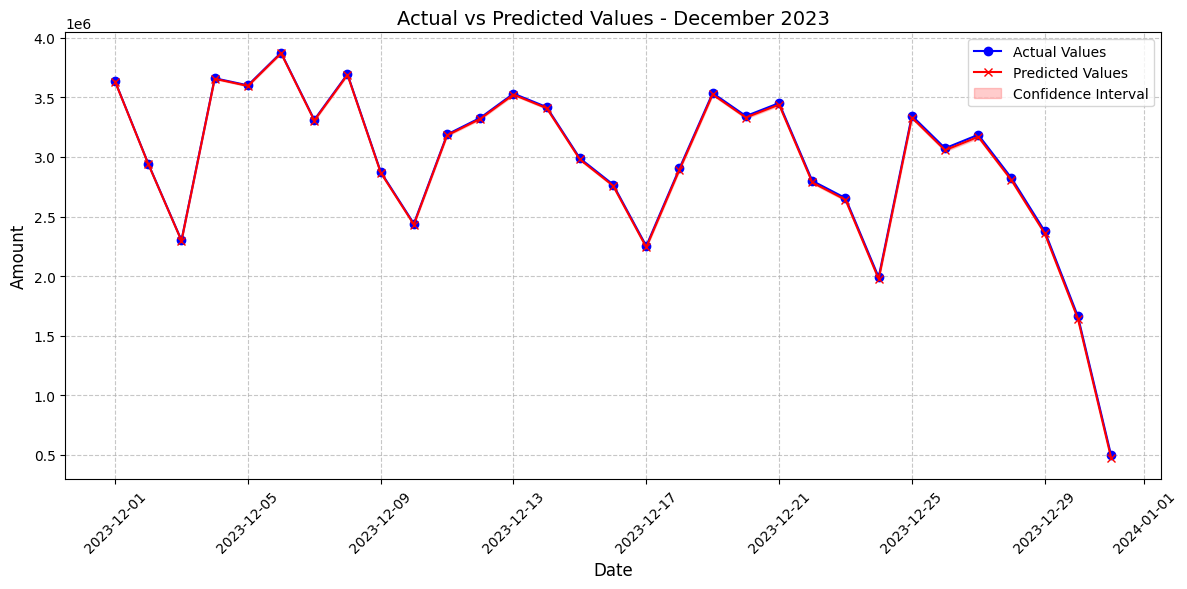


December 2023 Statistics:
Average Actual Value: $2,949,993.35
Average Predicted Value: $2,939,431.35
MAE: $10,562.00


In [ ]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
# Load the data
df = pd.read_csv('/content/drive/MyDrive/Хакатоны/CUP_IT_25/Датасеты итоговые/daily.csv')  # Replace with your actual file path

# Prepare regressors
regressors = [
    'unique_patients',
    'hospital_ammount',
    'non_hospital_ammount',
    'hospital_unique_patients',
    'unique_service_codes',
    'high_cost_proportion',
    'service_code_hhi',
    'mean_ammount',
    'total_racords',
    'lag_1',
    'lag_7',
    'lag_14',
    'EMA_7',
    'EMA_14'
]

# Prepare data for Prophet
df_prophet = df[['service_date', 'total_amount_net'] + regressors].copy()
df_prophet.columns = ['ds', 'y'] + regressors
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
df_prophet = df_prophet.dropna()

# Split training data (excluding last 60 days)
train_df = df_prophet[:-60]

# Initialize and fit the model
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

for regressor in regressors:
    model.add_regressor(regressor)

model.fit(train_df)

# Create future dataframe and forecast
future_dates = model.make_future_dataframe(periods=60)
for regressor in regressors:
    future_dates[regressor] = df_prophet[regressor]
forecast = model.predict(future_dates)

model.plot(forecast)
# Filter for December 2023
forecast_dec = forecast[forecast['ds'].dt.month == 12][forecast['ds'].dt.year == 2023]
actual_dec = df_prophet[df_prophet['ds'].dt.month == 12][df_prophet['ds'].dt.year == 2023]

# Create Matplotlib plot
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(actual_dec['ds'], actual_dec['y'],
         label='Actual Values', color='blue', marker='o', linestyle='-')

# Plot predicted values
plt.plot(forecast_dec['ds'], forecast_dec['yhat'],
         label='Predicted Values', color='red', marker='x', linestyle='-')

# Plot confidence intervals
plt.fill_between(forecast_dec['ds'],
                 forecast_dec['yhat_lower'],
                 forecast_dec['yhat_upper'],
                 color='red', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('Actual vs Predicted Values - December 2023', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Amount', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

# Print some basic statistics
print("\nDecember 2023 Statistics:")
print(f"Average Actual Value: ${actual_dec['y'].mean():,.2f}")
print(f"Average Predicted Value: ${forecast_dec['yhat'].mean():,.2f}")
print(f"MAE: ${abs(actual_dec['y'].values - forecast_dec['yhat'].values).mean():,.2f}")